In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops
L = tf.layers

In [2]:
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
data_dir = os.path.expanduser('/home/paperspace/Insight/video-representations/data/downsampled')
filenames = os.listdir(data_dir)

def load_data(filename):
    with np.load(os.path.join(data_dir, filename)) as f:
        frames = [arr for name, arr, in f.items()]
    
    return list(frames[0])

def pad_frames(frames, final_length=20):
    pad = np.zeros((3, 60, 80), dtype=np.int8)[np.newaxis, :, :, :]
    if frames.shape[0] <=20 :
        padstack = np.repeat(pad, final_length - frames.shape[0], axis=0)
        return np.concatenate((padstack, frames))
    else:
        return frames

def load_all(interleaves=0, everyn=1):
    frames = [load_data(filename) for filename in filenames[interleaves::everyn]]
    X = np.concatenate([np.concatenate([f[:-1] for f in frame]) for frame in frames])
    y = np.concatenate([np.concatenate([f[1:] for f in frame]) for frame in frames])
    return X, y

In [4]:
X_all, y_all = load_all(everyn=4)
# X2, y2 = load_all(interleaves=1, everyn=2)
# X_all = np.concatenate([X1, X2])
# y_all = np.concatenate([y1, y2])

idxs = np.arange(X_all.shape[0])
np.random.shuffle(idxs)
train_idxs = idxs[2*(idxs.size//10):]
test_idxs = idxs[:2*(idxs.size//2)]

X_train = X_all[train_idxs]
y_train = y_all[train_idxs]
X_test = X_all[test_idxs]
y_test = y_all[test_idxs]

# X_test, y_test = load_all(interleaves=1, everyn=2)

print(X_train.shape, X_train.nbytes / 1000000)

(29699, 3, 60, 80) 1710.6624


In [5]:
def selu(x):
    with ops.name_scope('elu'):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
    return scale * tf.where(x >= 0.0, x, alpha * tf.nn.elu(x))

def lrelu(x, alpha=.03):
    return tf.maximum(alpha*x, x)

def dense_reshape(incoming, units, **kwargs):
    shape = incoming.get_shape().as_list()
    newdim = np.prod(shape[1:])
    reshaped = tf.reshape(incoming, (-1, newdim))
    return L.dense(reshaped, units=units, **kwargs)

def encoder(image):
    input_layer = tf.reshape(image, (-1, 60, 80, 3))
    
    conv1 = L.conv2d(
        input_layer, filters=16, kernel_size=3, activation=selu
    )
    
    conv2 = L.conv2d(
        conv1, filters=16, kernel_size=3, activation=selu
    )
    
    conv3 = L.conv2d(
        conv2, filters=16, kernel_size=5, activation=selu
    )
    
    conv4 = L.conv2d(
        conv3, filters=32, kernel_size=5, activation=selu
    )
    
    shape = conv4.get_shape().as_list()
    print(shape)
    newdim = shape[1] * shape[2] * shape[3]
    print(newdim)
    conv4_flat = tf.reshape(conv4, (-1, newdim))
    print(conv4_flat.shape)
    
    dense1 = dense_reshape(conv4, units=1024, activation=selu)
    
    return dense1

def transitions(encoded):
    outputs = None
    return outputs

def decoder(encoded):
    dense1 = L.dense(encoded, units=104448, activation=selu)
    dense1_reshaped = tf.reshape(dense1, (-1, 48, 68, 32))
    
    deconv1 = L.conv2d_transpose(
        dense1_reshaped, filters=16, kernel_size=5, activation=selu
    )
    
    deconv2 = L.conv2d_transpose(
        deconv1, filters=16, kernel_size=5, activation=selu
    )
    
    deconv3 = L.conv2d_transpose(
        deconv2, filters=16, kernel_size=3, activation=selu
    )
    
    deconv4 = L.conv2d_transpose(
        deconv3, filters=3, kernel_size=3, activation=lrelu
    )
    
    deconv3_reshaped = tf.transpose(deconv4, perm=(0, 3, 1, 2))
    
    return deconv3_reshaped

In [6]:
epochs = 21
tf.reset_default_graph()

input_var = tf.placeholder(dtype=tf.float32, shape=(None, 3, 60, 80), name='input')
target_var = tf.placeholder(dtype=tf.float32, shape=(None, 3, 60, 80), name='target')

encoded = encoder(input_var)
decoded = decoder(encoded)

loss = tf.reduce_mean(tf.pow(decoded - target_var, 2))
train_step = tf.train.AdamOptimizer().minimize(loss)
saver = tf.train.Saver()

[None, 48, 68, 32]
104448
(?, 104448)


In [7]:
def iterate_minibatches(inputs, targets, batchsize=32, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        idxs = np.arange(len(inputs))
        np.random.shuffle(idxs)

    for idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = idxs[idx:idx + batchsize]
        else:
            excerpt = slice(idx, idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [8]:
os.makedirs('tmp/models', exist_ok=True)
init = tf.global_variables_initializer()

with tf.Session() as sesh:
    
    sesh.run(init)
        
    train_trace = []
    validation_trace = []
    
    batch_no = 0
    current_loss = 0
    
    for batch in iterate_minibatches(X_test, y_test, batchsize=128):
        X_batch, y_batch = batch
        current_loss += loss.eval({input_var: X_batch, target_var: y_batch})
        batch_no += 1
        
    print('Initial loss: {}'.format(current_loss / batch_no))
    saver.save(sesh, 'tmp/models/prototype_ae initial.ckpt')
    
    for epoch in range(epochs):
        batch_no = 0
        current_loss = 0
        
        for batch in iterate_minibatches(X_train, y_train, batchsize=64, shuffle=True):
            X_batch, y_batch = batch
            train_step.run({input_var: X_batch, target_var: y_batch})
            
            batch_loss = loss.eval({input_var: X_batch, target_var: y_batch})
            current_loss += batch_loss
            batch_no += 1
            train_trace.append(batch_loss)
            
            if batch_no % 100 == 0:
                print('\t\t', current_loss / batch_no)
            
        print('Epoch {} train loss: {}'.format(epoch, current_loss / batch_no))
        
        if epoch % 5 == 0:
            saver.save(sesh, 'tmp/models/prototype_ae epoch {}.ckpt'.format(epoch))
        
        val_loss = 0
        batch_no = 0
        
        for batch in iterate_minibatches(X_test, y_test, batchsize=128, shuffle=True):
            X_batch, y_batch = batch
            
            batch_loss = loss.eval({input_var: X_batch, target_var: y_batch})
            val_loss += batch_loss
            batch_no += 1
            
        print('\t test loss: {}'.format(val_loss / batch_no))
    
    train_outputs = []
    for batch in iterate_minibatches(X_train, y_train, batchsize=128, shuffle=False):
        X_batch, y_batch = batch
        output = sesh.run(decoded, {input_var: X_batch})
        train_outputs.append(output)
    
    test_outputs = []
    for batch in iterate_minibatches(X_test, y_test, batchsize=128, shuffle=False):
        X_batch, y_batch = batch
        output = sesh.run(decoded, {input_var: X_batch})
        test_outputs.append(output)
    
#     saver.save(sesh, 'tmp/models/prototype_ae.ckpt')

Initial loss: 14181.764129849138
		 6148.20864746
		 4108.6096283
		 3296.34541097
		 2857.97131927
Epoch 0 train loss: 2661.400617665258
	 test loss: 1393.998207671067
		 1329.31467529
		 1326.40512207
		 1293.84082255
		 1265.68397522
Epoch 1 train loss: 1248.575358686776
	 test loss: 1142.0075595198007
		 1089.18270996
		 1076.21963776
		 1072.08086934
		 1066.08735947
Epoch 2 train loss: 1060.401131860141
	 test loss: 1011.7354553222656
		 979.395917358
		 975.900897522
		 972.737873332
		 964.907264099
Epoch 3 train loss: 960.9807637971023
	 test loss: 932.4398517477101
		 907.213131104
		 889.951138916
		 885.813745931
		 881.622332916
Epoch 4 train loss: 883.9244340041588
	 test loss: 893.4916061927532
		 834.546799927
		 825.510339966
		 821.291513672
		 819.443656464
Epoch 5 train loss: 818.2306390959641
	 test loss: 817.7642232960668
		 742.449679565
		 741.455891113
		 742.992000326
		 745.923871155
Epoch 6 train loss: 750.7712848268707
	 test loss: 783.4970644194505
		 700.

In [14]:
lim = 30
new_test_frames = np.concatenate(test_outputs[:lim]).transpose((0, 2, 3, 1)) / 255
new_train_frames = np.concatenate(train_outputs[:lim]).transpose((0, 2, 3, 1)) / 255
X_test_ims = X_test[:lim].transpose((0, 2, 3, 1)) / 255
X_train_ims = X_train[:lim].transpose((0, 2, 3, 1)) / 255
# new_frames = (new_frames + output.min()) / output.max()

In [10]:
new_frames[9].shape

(60, 80, 3)

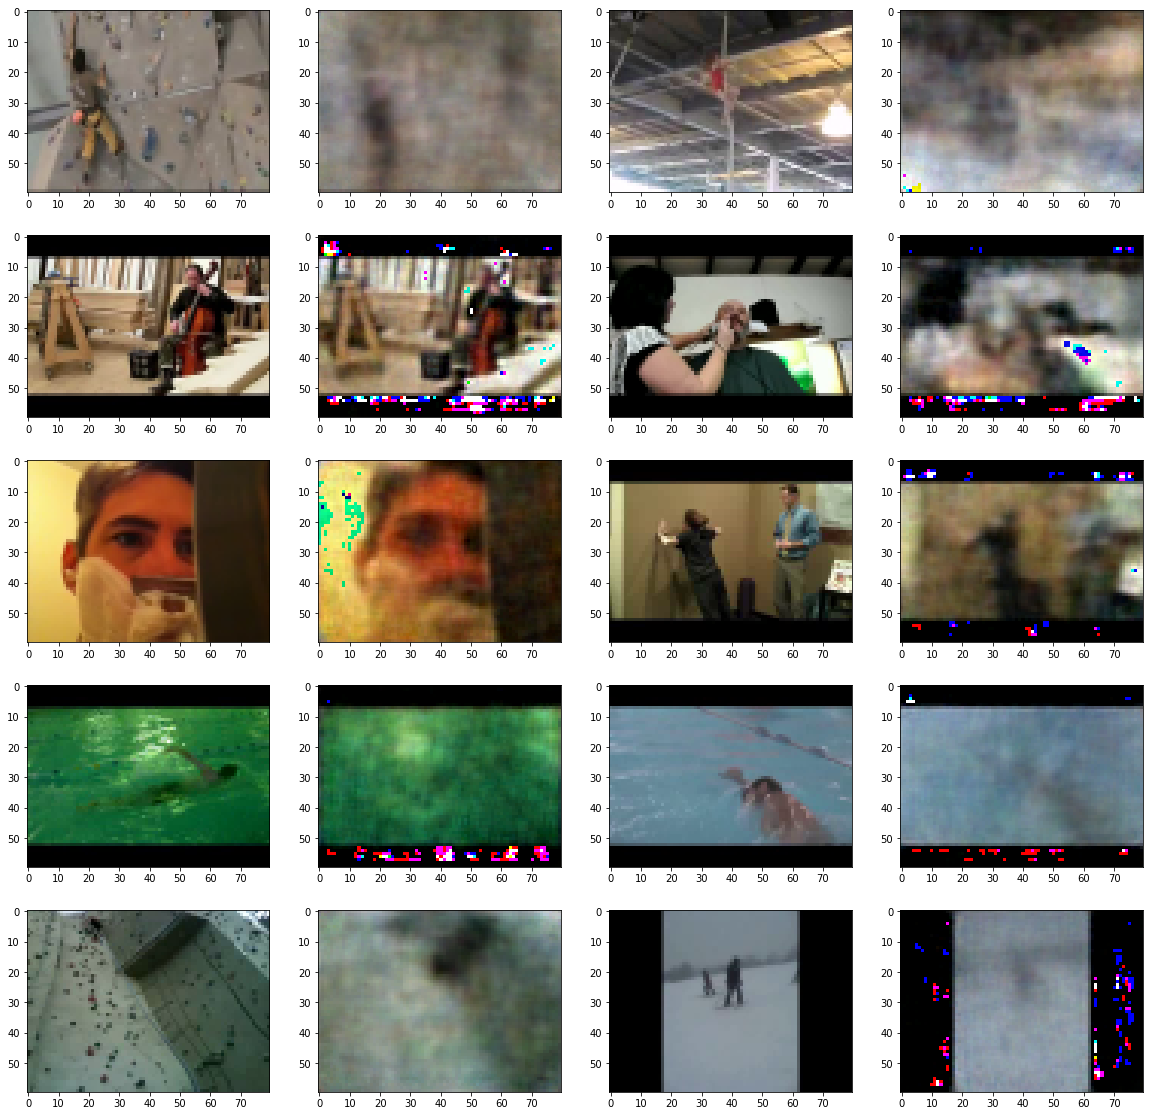

In [23]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
probe = 3

for i in range(5):
    for j in range(4):
        ax = axes[i, j]
        if j == 0:
            ax.imshow(X_train_ims[probe+(i//5)+2*i])
        elif j == 1:
            ax.imshow(new_train_frames[probe+(i//5)+2*i])
        elif j == 2:
            ax.imshow(X_test_ims[probe+(i//5)+2*i])
        else:
            ax.imshow(new_test_frames[probe+(i//5)+2*i])